# 18.8 - Regression Challenge

In [159]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [160]:
house.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [161]:
house.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


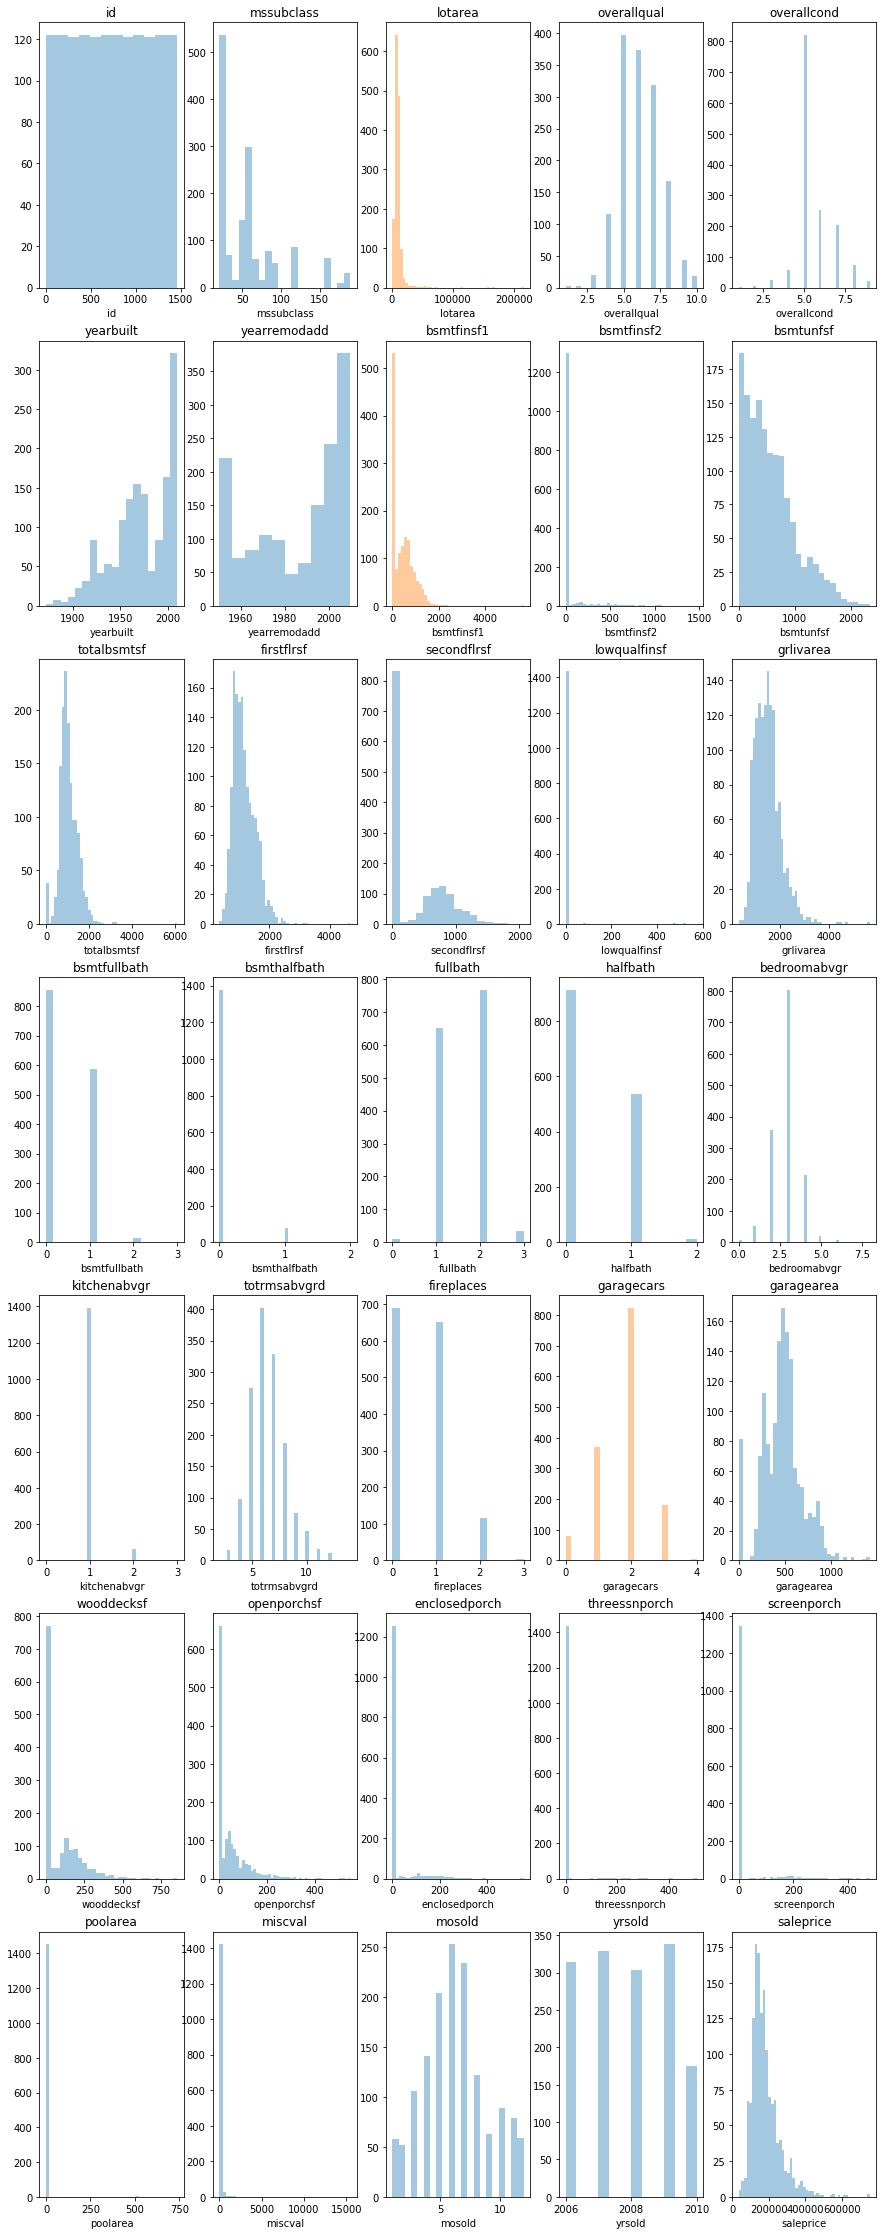

In [162]:
plt.figure(figsize=(15,40))
s = 1

for c in range(house.shape[1]):
    try:
        plt.subplot(7,5,s)
        plt.title(house.columns[c])
        sns.distplot(house.iloc[:,c], kde=False)
        s += 1
    except:
        pass

In [163]:
# Some columns such as pool square footage, an Nan value should be imputed with 0, not 
# the column mean. The following code imputes a 0 value when the mode of a column is 0, 
# imputes the mean for all other numeric variables

for col in house.columns:
    if house[col].mode()[0] == 0:
        house[col].fillna(0, inplace=True)
    elif ((house.dtypes[col] == 'float64') | (house.dtypes[col] == 'int64')):
        house[col].fillna(house[col].mean(), inplace=True)

In [164]:
house.corr()['saleprice'][:-1]

id              -0.021917
mssubclass      -0.084284
lotfrontage      0.334901
lotarea          0.263843
overallqual      0.790982
overallcond     -0.077856
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.472614
bsmtfinsf1       0.386420
bsmtfinsf2      -0.011378
bsmtunfsf        0.214479
totalbsmtsf      0.613581
firstflrsf       0.605852
secondflrsf      0.319334
lowqualfinsf    -0.025606
grlivarea        0.708624
bsmtfullbath     0.227122
bsmthalfbath    -0.016844
fullbath         0.560664
halfbath         0.284108
bedroomabvgr     0.168213
kitchenabvgr    -0.135907
totrmsabvgrd     0.533723
fireplaces       0.466929
garageyrblt      0.470177
garagecars       0.640409
garagearea       0.623431
wooddecksf       0.324413
openporchsf      0.315856
enclosedporch   -0.128578
threessnporch    0.044584
screenporch      0.111447
poolarea         0.092404
miscval         -0.021190
mosold           0.046432
yrsold          -0.028923
Name: saleprice, dtype: float64

In [165]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import matplotlib.pyplot as plt

def display_results(test, pred):
    plt.scatter(test, pred)
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.plot(test, test, color="red")
    plt.show()

    print('R-Squared: \t\t\t{}'.format(round(r2_score(test, pred),4)))
    print('Mean Absolute Error: \t\t{}'.format(round(mean_absolute_error(test, pred)),0))
    print('Mean Squared Error: \t\t{}'.format(round(mse(test, pred)),0))
    print('Root Mean Squared Error: \t{}'.format(round(rmse(test, pred)),0))
    print('Mean Absolute Percentage Error: {}%'.format(round(np.mean(np.abs((test-pred)/test)*100),2)))

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(house.drop(columns=['id','saleprice']), house['saleprice'], test_size = 0.2, random_state = 465)

X_train_1 = X_train[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X_train_1 = sm.add_constant(X_train_1)

results = sm.OLS(y_train, X_train_1).fit()

X_test_1 = X_test[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X_test_1 = sm.add_constant(X_test_1)
y_pred_1 = results.predict(X_test_1)

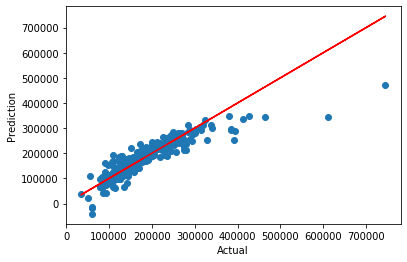

R-Squared: 			0.7829
Mean Absolute Error: 		24169.0
Mean Squared Error: 		1457655931.0
Root Mean Squared Error: 	38179.0
Mean Absolute Percentage Error: 14.83%


In [167]:
display_results(y_test, y_pred_1)

We have a lot of numeric variables that aren't being used. Let's try using a regularized model that selects from all our numeric variables.

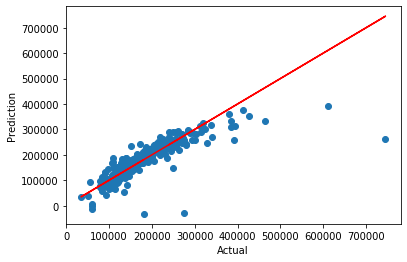

R-Squared: 			0.6622
Mean Absolute Error: 		24510.0
Mean Squared Error: 		2267888246.0
Root Mean Squared Error: 	47622.0
Mean Absolute Percentage Error: 14.0%


In [168]:
alphas=[10 ** i for i in range(-10,40)]
numerics = list((X_train.dtypes == 'int64') | (X_train.dtypes == 'float64'))


X_train_2 = X_train.iloc[:,numerics]
X_train_2 = X_train_2.drop(columns=['mssubclass'])
X_train_2 = sm.add_constant(X_train_2)

lasso = LassoCV(alphas=alphas)
lasso = lasso.fit(X_train_2, y_train)

X_test_2 = X_test.iloc[:,numerics]
X_test_2 = sm.add_constant(X_test_2)
X_test_2 = X_test_2.drop(columns=['mssubclass'])
y_pred_2 = lasso.predict(X_test_2)

display_results(y_test, y_pred_2)

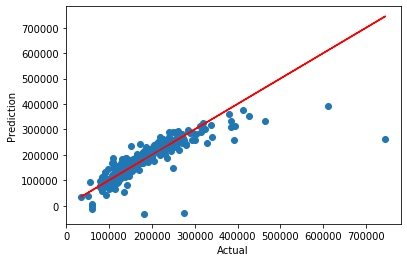

R-Squared: 			0.662
Mean Absolute Error: 		24509.0
Mean Squared Error: 		2269388345.0
Root Mean Squared Error: 	47638.0
Mean Absolute Percentage Error: 14.0%


In [169]:
ridge = RidgeCV(alphas=alphas)
ridge = ridge.fit(X_train_2, y_train)
y_pred_3 = ridge.predict(X_test_2)

display_results(y_test, y_pred_3)

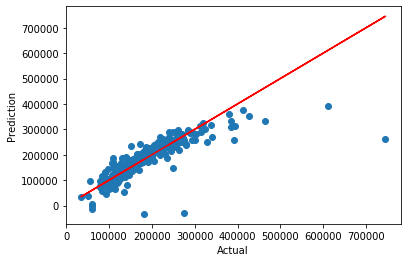

R-Squared: 			0.661
Mean Absolute Error: 		24507.0
Mean Squared Error: 		2276052162.0
Root Mean Squared Error: 	47708.0
Mean Absolute Percentage Error: 14.01%


In [170]:
elastic = ElasticNetCV(alphas=alphas)
elastic = elastic.fit(X_train_2, y_train)
y_pred_4 = elastic.predict(X_test_2)

display_results(y_test, y_pred_4)

For all 3 of our regularized models, the r-squared and RMSE is significantly worse than our linear regression model (with only 8 independent variables), but our MAPE is significantly better. It may be the case that our regularized models do better with observations in our main "cluster," but does significantly worse for our outlier values.

We have to address the non-normality of some of the factors. For each variable that appears to be distributed non-normally, we test whether performing a log transform or a box-cox transform would result in a more normal distribution, then perform that on the factor.

In [171]:
from scipy.stats import normaltest
from scipy.stats import boxcox



for col in X_test_2.columns[1:-2]: # I excluded the constant term and the month and year sold
    if normaltest(house[col])[1]>.05:
        pass
    bc,_ = boxcox(house[col]+1)
    if normaltest(np.log(house[col]))[0] < normaltest(bc)[0]:
        house[col] = np.log(house[col])
        house[col] = np.log(house[col])
    else:
        house[col] = bc
        bc_train,_ = boxcox(house[col]+1)
        house[col] = bc_train
        
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(house.drop(columns=['id','saleprice']), house['saleprice'], test_size = 0.2, random_state = 465)


In [172]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(house.drop(columns=['id','saleprice']), house['saleprice'], test_size = 0.2, random_state = 465)

In [173]:
numerics = list((X_train_3.dtypes == 'int64') | (X_train_3.dtypes == 'float64'))

X_train_3 = X_train_3.iloc[:,numerics]
X_train_3['const'] = 1

X_test_3 = X_test_3.iloc[:,numerics]
X_test_3['const'] = 1

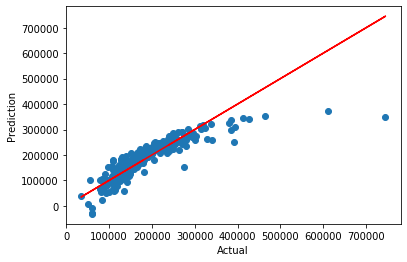

R-Squared: 			0.7535
Mean Absolute Error: 		24142.0
Mean Squared Error: 		1654655978.0
Root Mean Squared Error: 	40677.0
Mean Absolute Percentage Error: 14.56%


In [174]:
elastic = ElasticNetCV(alphas=alphas)
elastic = elastic.fit(X_train_3, y_train)
y_pred_5 = elastic.predict(X_test_3)

display_results(y_test, y_pred_5)

In [175]:
X_train_4 = X_train_3[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X_train_4 = sm.add_constant(X_train_4)

X_test_4 = X_test_3[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X_test_4 = sm.add_constant(X_test_4)


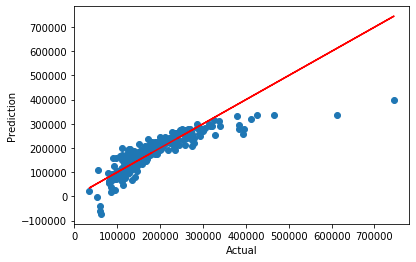

R-Squared: 			0.7276
Mean Absolute Error: 		26592.0
Mean Squared Error: 		1829135401.0
Root Mean Squared Error: 	42768.0
Mean Absolute Percentage Error: 16.91%


In [176]:
results = sm.OLS(y_train, X_train_4).fit()
y_pred_6 = results.predict(X_test_4)
display_results(y_test, y_pred_6)

I imported the Case-Shiller Housing Index to account for price fluctuations from the housing market more generally. Given a set of factors, a house will sell for more or less than usual if the housing market is up or down. I also imported average 30-year US mortgage rates by month.

In [177]:
case_shiller = pd.read_csv('CSUSHPINSA.csv', header=0)

case_shiller['DATE'] = case_shiller['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
case_shiller['year'] = case_shiller['DATE'].apply(lambda x: x.year)
case_shiller['month'] = case_shiller['DATE'].apply(lambda x: x.month)

X_train_3 = pd.merge(X_train_3, case_shiller, left_on=['mosold','yrsold'], right_on=['month','year'], how='left')
X_test_3 = pd.merge(X_test_3, case_shiller, left_on=['mosold','yrsold'], right_on=['month','year'], how='left')



In [178]:
interest = pd.read_csv('MORTGAGE30US.csv')
interest['DATE'][0]

interest['DATE'] = interest['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
interest['year'] = interest['DATE'].apply(lambda x: x.year)
interest['month'] = interest['DATE'].apply(lambda x: x.month)

X_train_3 = pd.merge(X_train_3, interest, left_on=['mosold','yrsold'], right_on=['month','year'], how='left')
X_test_3 = pd.merge(X_test_3, interest, left_on=['mosold','yrsold'], right_on=['month','year'], how='left')

X_train_3 = X_train_3.drop(columns=['mssubclass', 'mosold', 'yrsold', 'DATE_x', 'year_x', 'month_x', 'DATE_y', 'year_y', 'month_y'])
X_test_3 = X_test_3.drop(columns=['mssubclass', 'mosold', 'yrsold', 'DATE_x', 'year_x', 'month_x', 'DATE_y', 'year_y', 'month_y'])

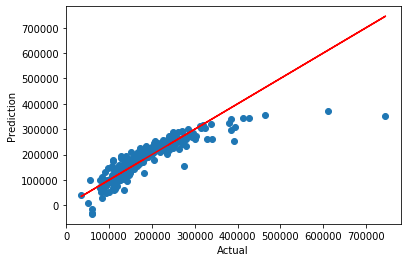

R-Squared: 			0.754
Mean Absolute Error: 		24117.0
Mean Squared Error: 		1651551569.0
Root Mean Squared Error: 	40639.0
Mean Absolute Percentage Error: 14.63%


In [180]:
elastic = ElasticNetCV(alphas=alphas)
elastic = elastic.fit(X_train_3, y_train)
y_pred_7 = elastic.predict(X_test_3)

display_results(y_test, y_pred_7)

While the MAPE isn't down to the level that our first regularized models were, our other measures of fit are some of our best yet. It does appear that adding in economic variables improved our model.